## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import NormalInverseGammaPriorLinearRegression
from src.models.bayesian_nn import BayesianNN
from src.utils import id
from src.utils import _torch_expy2 as expy2
from src.utils import _torch_l1_projection as l1_projection

from src.attacks.point_attacks import attack, attack_fgsm

import numpy as np
import torch
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
print(f"X_train shape: {X_train.shape}")

X_train shape: (3428, 11)


In [7]:
import numpyro
numpyro.set_host_device_count(8)

In [8]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/bayesian_3nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/bayesian_3nn')

/Users/pgarc/projects/AdvReg/src/models/bayesian_nn.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.posterior_samples = torch.load(path)


In [9]:
n_samples = 100
all_importances = []
for i in range(100):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    baseline_pred = model.sample_predictive_distribution(x, n_samples).mean()
    baseline_score = (y_test[i] - baseline_pred) ** 2

    importances = []
    for j in range(X_test.shape[1]):
        scores = []
        X_mod = x.clone()
        X_mod[j, :] += np.random.uniform(-0.2, 0.2)
        preds = model.sample_predictive_distribution(X_mod, n_samples).mean()
        score = (y_test[i] - preds) ** 2
        importances.append(score - baseline_score)

    all_importances.append(importances)
all_importances = np.array(all_importances)
importances = all_importances.mean(axis=0)
# Features by importance
importances = np.array(importances)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")

# TOP 7 features
TOP_FEATURES = list(indices[:7])
# worse 7 features
WORSE_FEATURES = list(indices[-7:])

Feature ranking:
1. Feature 7 (0.6414941549301147)
2. Feature 3 (0.2775610089302063)
3. Feature 5 (0.20831523835659027)
4. Feature 1 (0.06909288465976715)
5. Feature 4 (0.027108464390039444)
6. Feature 6 (0.01326070912182331)
7. Feature 0 (-0.0034029546659439802)
8. Feature 8 (-0.013863814063370228)
9. Feature 10 (-0.02335330657660961)
10. Feature 2 (-0.023721760138869286)
11. Feature 9 (-0.04550843685865402)


In [10]:
# Fit the attacker model: Different arquitecture
attack_model1 = BayesianNN(input_dim=X_train.shape[1], hidden_units=4)
try:
    attack_model1.load('../src/models/bayesian_4nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model1.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    attack_model1.save('../src/models/bayesian_4nn')

In [11]:
# Fit the attacker model: Smaller dataset
attack_model2 = BayesianNN(input_dim=X_train.shape[1], hidden_units=4)
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]
try:
    attack_model2.load('../src/models/bayesian_3nn_small')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model2.fit(
        X_train_subset, 
        y_train_subset,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    attack_model2.save('../src/models/bayesian_3nn_small')

In [12]:
# Fit the attacker model: Not all features
X_train_subset = X_train[:, TOP_FEATURES]
attack_model3 = BayesianNN(input_dim=X_train_subset.shape[1], hidden_units=3)
try:
    attack_model3.load('../src/models/bayesian_3nn_topfeatures')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model3.fit(
        X_train_subset, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    attack_model3.save('../src/models/bayesian_3nn_topfeatures')

In [13]:
# Fit the attacker model: Not all features
X_train_subset = X_train[:, WORSE_FEATURES]
attack_model4 = BayesianNN(input_dim=X_train_subset.shape[1], hidden_units=3)
try:
    attack_model4.load('../src/models/bayesian_3nn_worsefeatures')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    attack_model4.fit(
        X_train_subset, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    attack_model4.save('../src/models/bayesian_3nn_worsefeatures')

## Attack with exp(y^2/100) as objective function

0


<>:78: SyntaxWarning: invalid escape sequence '\e'
<>:78: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_53967/3387270693.py:78: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_53967/3387270693.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((func_mean - y_star) ** 2)


1
2
3


Text(0, 0.5, 'Loss')

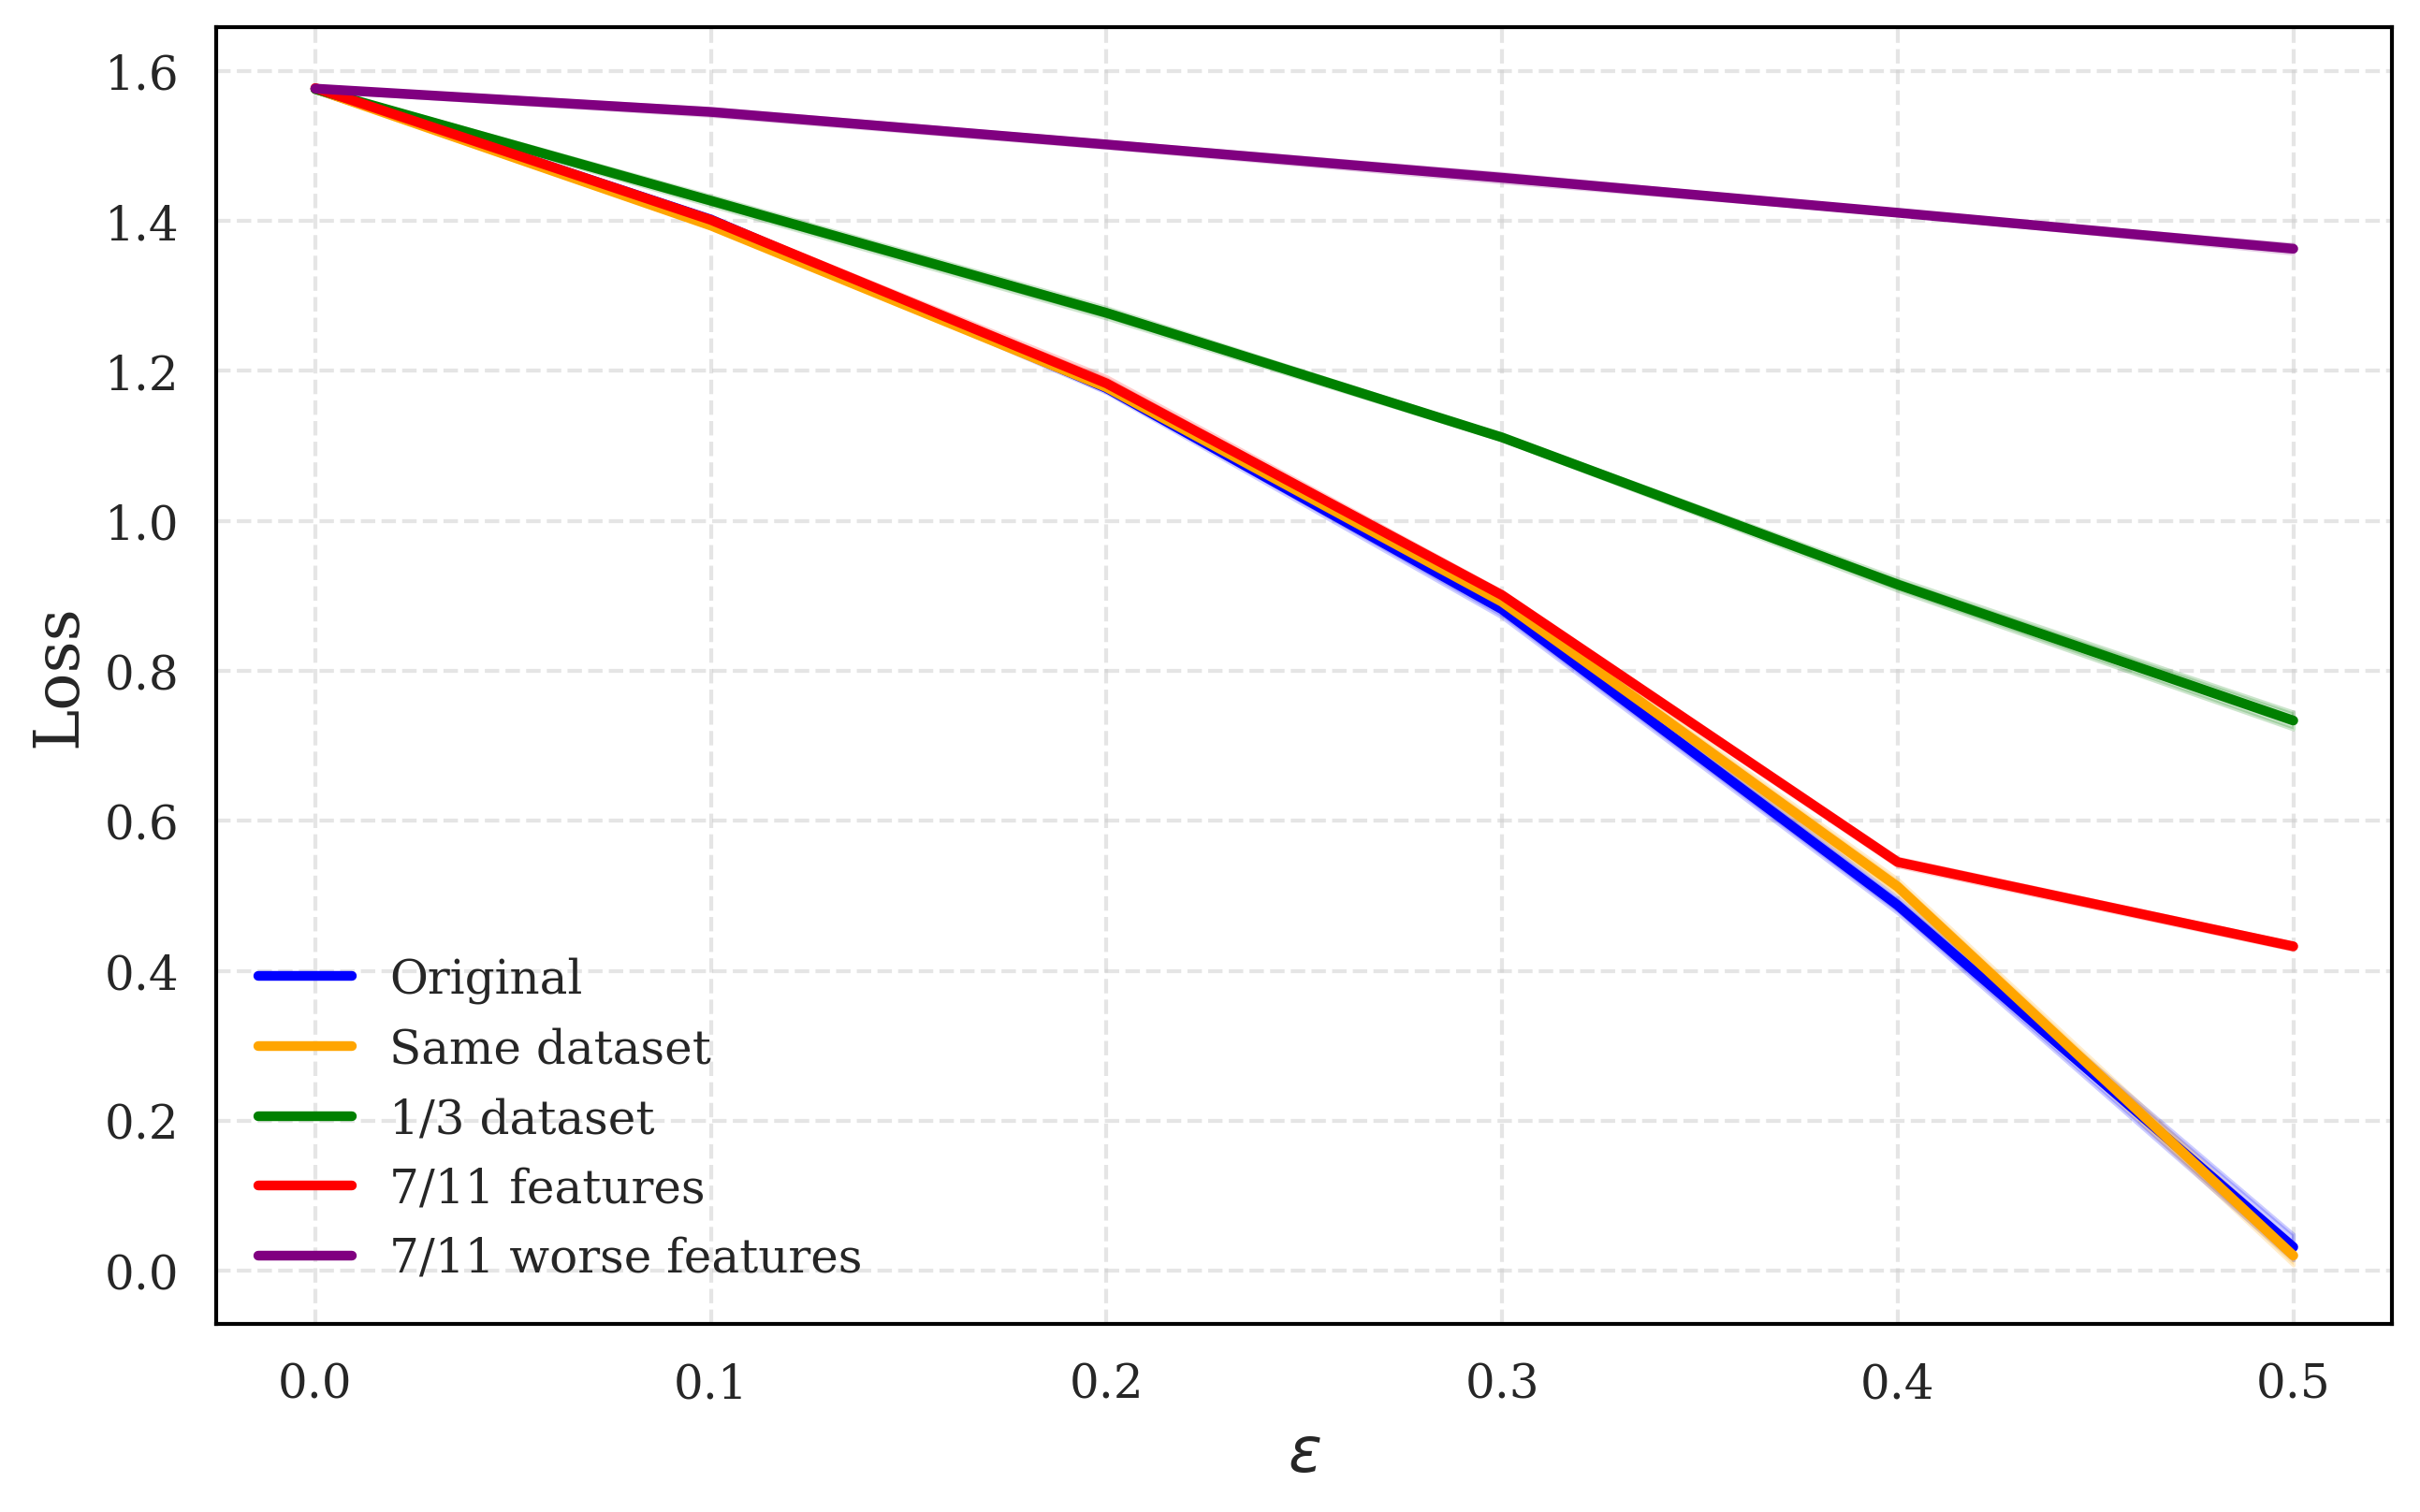

In [14]:
# Plot loss as a function of the size of the perturbation for reparametrization trick attack
x_adv = torch.tensor(X_test[17, :].copy(), dtype=torch.float32, requires_grad=True)
y_star = 3.0
losses_original_rep = []
losses_total_rep1 = []
losses_total_rep2 = []
losses_total_rep3 = []
losses_total_rep4 = []
epsilons = np.linspace(0, .5, 6)


def compute_loss_rep(epsilon, attack_model):
    if attack_model == attack_model3:
        x_adv = torch.tensor(X_test[17, TOP_FEATURES].copy(), dtype=torch.float32, requires_grad=True)
        x_adv_original = np.array(X_test[17, :].copy(), dtype=np.float32)
    elif attack_model == attack_model4:
        x_adv = torch.tensor(X_test[17, WORSE_FEATURES].copy(), dtype=torch.float32, requires_grad=True)
        x_adv_original = np.array(X_test[17, :].copy(), dtype=np.float32)
    else:
        x_adv = torch.tensor(X_test[17, :].copy(), dtype=torch.float32, requires_grad=True)
    x_adv_values, loss_values, func_values = attack(x_adv, attack_model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2)    
    if attack_model == attack_model3:
        x_adv_original[TOP_FEATURES] = x_adv_values[-1]
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_original).unsqueeze(1), 1000)
    elif attack_model == attack_model4:
        x_adv_original[WORSE_FEATURES] = x_adv_values[-1]
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_original).unsqueeze(1), 1000)
    else:
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000)
    func_mean = torch.exp(y_adv ** 2 / 100).mean()
    return np.sqrt((func_mean - y_star) ** 2)


for _ in range(4):
    print(_)
    losses_rep0 = []
    losses_rep1 = []
    losses_rep2 = []
    losses_rep3 = []
    losses_rep4 = []

    for epsilon in epsilons:
        losses_rep0.append(compute_loss_rep(epsilon, model))
        losses_rep1.append(compute_loss_rep(epsilon, attack_model1))
        losses_rep2.append(compute_loss_rep(epsilon, attack_model2))
        losses_rep3.append(compute_loss_rep(epsilon, attack_model3))
        losses_rep4.append(compute_loss_rep(epsilon, attack_model4))
        
    losses_original_rep.append(losses_rep0)
    losses_total_rep1.append(losses_rep1)
    losses_total_rep2.append(losses_rep2)
    losses_total_rep3.append(losses_rep3)
    losses_total_rep4.append(losses_rep4)

# plot the mean and std of the losses
original_mean = np.mean(losses_original_rep, axis=0)
original_std = np.std(losses_original_rep, axis=0)
attack1_mean = np.mean(losses_total_rep1, axis=0)
attack1_std = np.std(losses_total_rep1, axis=0)
attack2_mean = np.mean(losses_total_rep2, axis=0)
attack2_std = np.std(losses_total_rep2, axis=0)
attack3_mean = np.mean(losses_total_rep3, axis=0)
attack3_std = np.std(losses_total_rep3, axis=0)
attack4_mean = np.mean(losses_total_rep4, axis=0)
attack4_std = np.std(losses_total_rep4, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(epsilons, np.mean(losses_original_rep, axis=0), label='Original', color='blue')
plt.fill_between(epsilons, original_mean - original_std, original_mean + original_std, alpha=0.2, color='blue')
plt.plot(epsilons, np.mean(losses_total_rep1, axis=0), label='Same dataset', color='orange')
plt.fill_between(epsilons, attack1_mean - attack1_std, attack1_mean + attack1_std, alpha=0.2, color='orange')
plt.plot(epsilons, np.mean(losses_total_rep2, axis=0), label='1/3 dataset', color='green')
plt.fill_between(epsilons, attack2_mean - attack2_std, attack2_mean + attack2_std, alpha=0.2, color='green')
plt.plot(epsilons, np.mean(losses_total_rep3, axis=0), label='7/11 features', color='red')
plt.fill_between(epsilons, attack3_mean - attack3_std, attack3_mean + attack3_std, alpha=0.2, color='red')
plt.plot(epsilons, np.mean(losses_total_rep4, axis=0), label='7/11 worse features', color='purple')
plt.fill_between(epsilons, attack4_mean - attack4_std, attack4_mean + attack4_std, alpha=0.2, color='purple')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_53967/1254429574.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Text(0, 0.5, 'Loss')

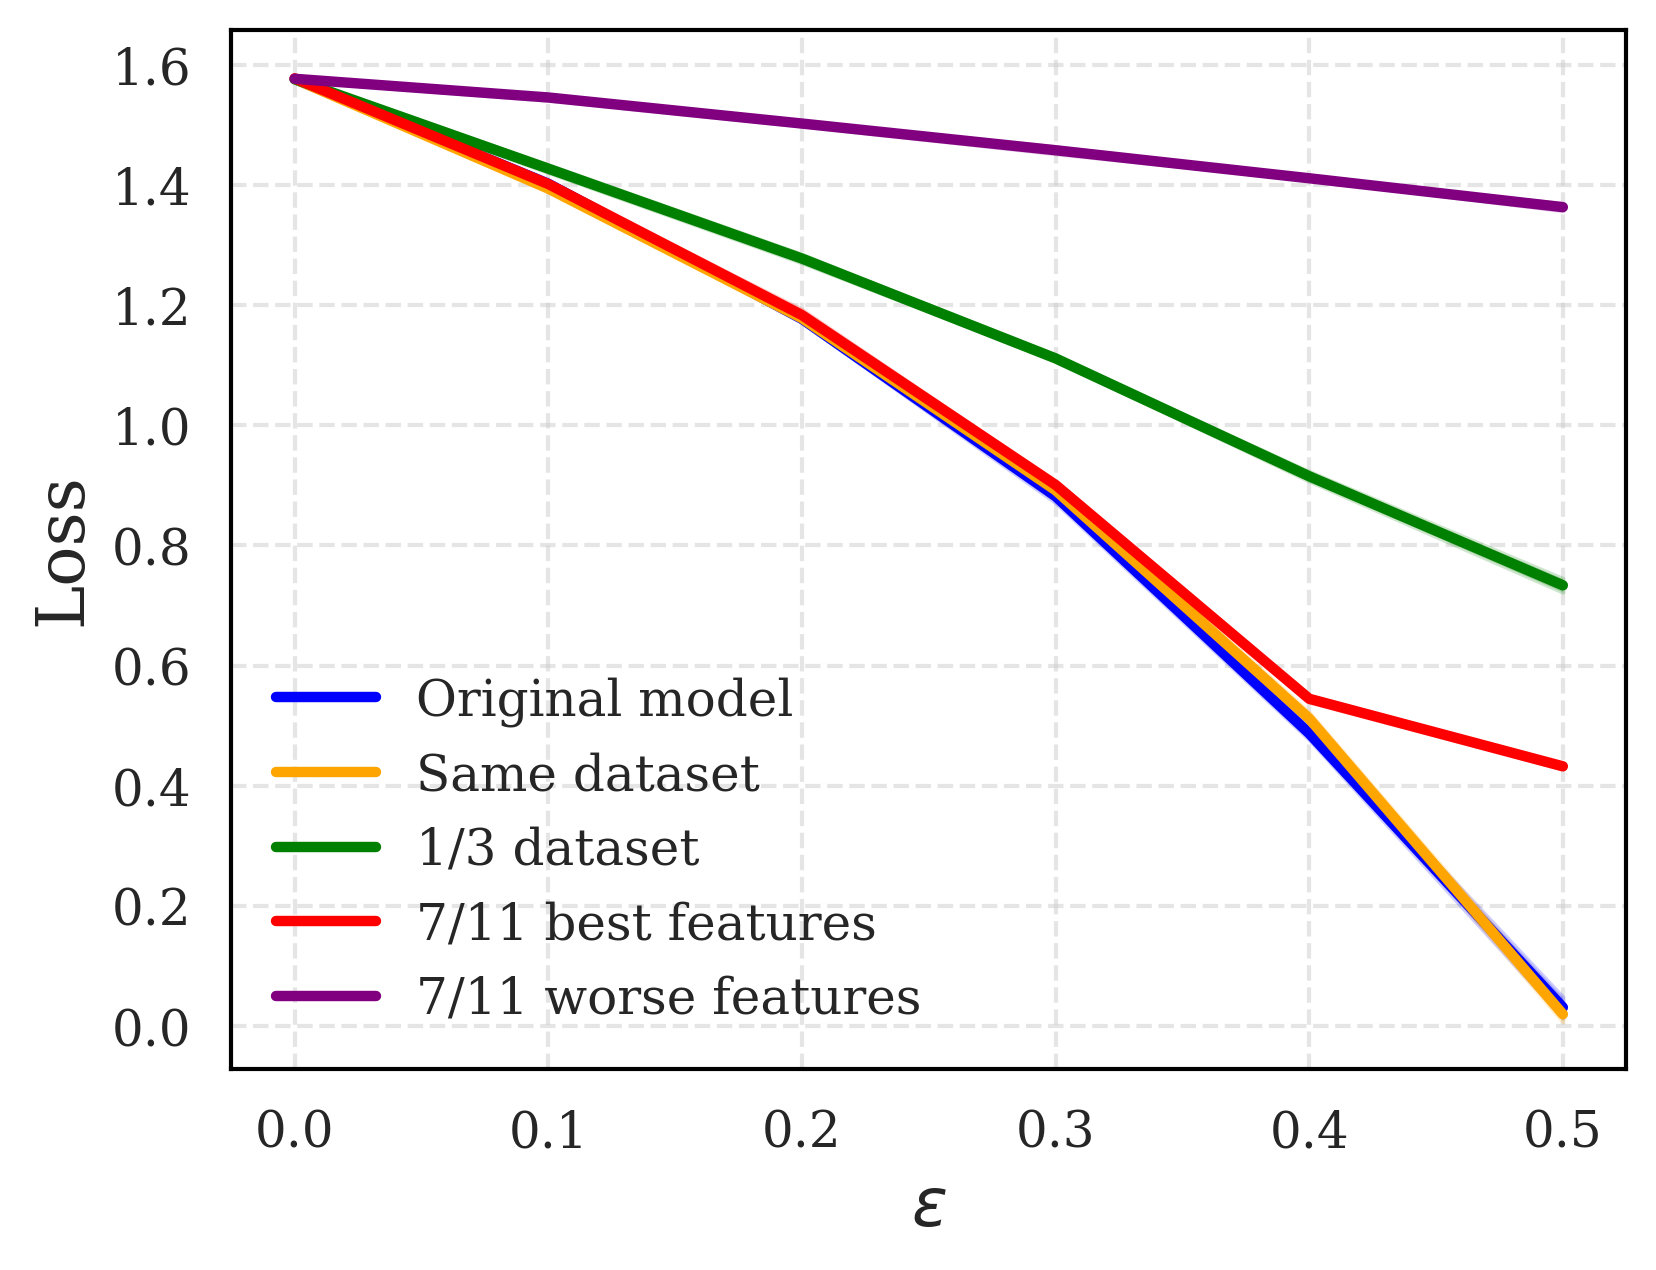

In [18]:
plt.figure(figsize=(6, 4.5))
plt.plot(epsilons, np.mean(losses_original_rep, axis=0), label='Original model', color='blue')
plt.fill_between(epsilons, original_mean - original_std, original_mean + original_std, alpha=0.2, color='blue')
plt.plot(epsilons, np.mean(losses_total_rep1, axis=0), label='Same dataset', color='orange')
plt.fill_between(epsilons, attack1_mean - attack1_std, attack1_mean + attack1_std, alpha=0.2, color='orange')
plt.plot(epsilons, np.mean(losses_total_rep2, axis=0), label='1/3 dataset', color='green')
plt.fill_between(epsilons, attack2_mean - attack2_std, attack2_mean + attack2_std, alpha=0.2, color='green')
plt.plot(epsilons, np.mean(losses_total_rep3, axis=0), label='7/11 best features', color='red')
plt.fill_between(epsilons, attack3_mean - attack3_std, attack3_mean + attack3_std, alpha=0.2, color='red')
plt.plot(epsilons, np.mean(losses_total_rep4, axis=0), label='7/11 worse features', color='purple')
plt.fill_between(epsilons, attack4_mean - attack4_std, attack4_mean + attack4_std, alpha=0.2, color='purple')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')

In [16]:
# Print results 
print('Epsilons:', np.round(epsilons, 2))
print(f"Losses original: {np.round(original_mean, 2)} ± {np.round(original_std, 2)}")
print(f"Losses attack with same dataset: {np.round(attack1_mean, 2)} ± {np.round(attack1_std, 2)}")
print(f"Losses attack with 1/3 dataset: {np.round(attack2_mean, 2)} ± {np.round(attack2_std, 2)}")
print(f"Losses attack with 7/11 best features: {np.round(attack3_mean, 2)} ± {np.round(attack3_std, 2)}")
print(f"Losses attack with 7/11 worst features: {np.round(attack4_mean, 2)} ± {np.round(attack4_std, 2)}")

Epsilons: [0.  0.1 0.2 0.3 0.4 0.5]
Losses original: [1.58 1.4  1.18 0.88 0.49 0.03] ± [0.   0.   0.01 0.01 0.01 0.02]
Losses attack with same dataset: [1.58 1.39 1.18 0.89 0.51 0.02] ± [0.   0.   0.   0.01 0.01 0.01]
Losses attack with 1/3 dataset: [1.58 1.43 1.28 1.11 0.92 0.73] ± [0.   0.01 0.01 0.   0.01 0.01]
Losses attack with 7/11 best features: [1.58 1.4  1.18 0.9  0.54 0.43] ± [0.   0.   0.01 0.01 0.01 0.  ]
Losses attack with 7/11 worst features: [1.58 1.55 1.5  1.46 1.41 1.36] ± [0.   0.   0.   0.01 0.   0.01]
